In [12]:
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.utils import np_utils
from scipy import io
import numpy as np
from sklearn.cross_validation import train_test_split
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

import seaborn as sns
sns.set_style("white")

In [4]:
data = io.loadmat("/media/zuziel/Windows/Users/Zuza/Documents/Programowanie/keras/notMNIST_small.mat")

In [5]:
X = data['images']
y = data['labels']
resolution = 28
classes = 10

X = np.transpose(X, (2, 0, 1))
X = X.reshape(X.shape[0], 1, 28, 28)

y = y.astype('int32')
X = X.astype('float32') / 255.

# 3 -> [0., 0., 0., 2., 0., 0., 0., 0., 0., 0.]
Y = np_utils.to_categorical(y, 10)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

Sieć z przykładu wykrywania standardowych znaków (http://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/)

Jedyna zmiana to dodanie atrybutu dim_ordering="th" rozwiązującego przy okazji problemy z Convolution2D, które wstąpiły w poprzednich sieciach. 

In [10]:
model = Sequential()
model.add(Convolution2D(32, 5, 5, border_mode='valid', input_shape=(1, 28, 28), activation='relu', dim_ordering="th"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(classes, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
from keras_ascii_sequential import sequential_model_to_ascii_printout
sequential_model_to_ascii_printout(model)

      OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

          Input   #####   (1, 28, 28)
  Convolution2D    \|/  -------------------       832     0.1%
           relu   #####   (32, 24, 24)
   MaxPooling2D   YYYYY -------------------         0     0.0%
                  #####   (16, 12, 24)
        Dropout    | || -------------------         0     0.0%
                  #####   (16, 12, 24)
        Flatten   ||||| -------------------         0     0.0%
                  #####   (4608,)
          Dense   XXXXX -------------------    589952    99.6%
           relu   #####   (128,)
          Dense   XXXXX -------------------      1290     0.2%
        softmax   #####   (10,)


Aby uniknąć problemów z zacinającym się komputerem i przy okazji nie tracić lepszych wyników na przypadkach testowych zdecydowałam o użyciu checkpointów:

In [13]:
# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(X_train, Y_train,
                    nb_epoch=10,
                    batch_size=32,
                    validation_data=(X_test, Y_test),
                    callbacks=callbacks_list)

Train on 14979 samples, validate on 3745 samples
Epoch 1/10
14979/14979 [==============================] - 22s - loss: 0.4467 - acc: 0.8744 - val_loss: 0.2912 - val_acc: 0.9140
Epoch 2/10
14979/14979 [==============================] - 19s - loss: 0.2532 - acc: 0.9265 - val_loss: 0.2683 - val_acc: 0.9210
Epoch 3/10
14979/14979 [==============================] - 18s - loss: 0.1943 - acc: 0.9419 - val_loss: 0.2338 - val_acc: 0.9282
Epoch 4/10
14979/14979 [==============================] - 18s - loss: 0.1525 - acc: 0.9524 - val_loss: 0.2283 - val_acc: 0.9311
Epoch 5/10
10272/14979 [===================>..........] - ETA: 5s - loss: 0.1135 - acc: 0.9654 

I tym razem wykonanie zacięło się, ale tym razem postanowiłam wyświetlić historię...

In [18]:
print(history.history)

{'acc': [0.87442419387142001, 0.92649709593430807, 0.94185192602977497, 0.95240002670405233, 0.96308164764400861, 0.96755457640696974, 0.97389678883770614, 0.97910407904399488, 0.98437812938113356, 0.98724881500767736], 'val_loss': [0.29120331959667128, 0.26833996476732364, 0.23381123845981502, 0.22829497490769554, 0.23702843468561668, 0.24847158662755991, 0.28679776680923114, 0.28128151874118879, 0.31086196644885716, 0.29120948173712508], 'val_acc': [0.91401869158878501, 0.92096128170894531, 0.92817089452603474, 0.93110814419225629, 0.93324432576769023, 0.9324432576769025, 0.93538050734312417, 0.93484646194926568, 0.92843791722296398, 0.93591455273698265], 'loss': [0.44674728952913528, 0.25318518711555676, 0.1942646781677608, 0.15248165754472967, 0.12005009162198384, 0.10180942926069771, 0.079412614230768619, 0.065191928755730225, 0.046767661234678709, 0.045105613903642712]}


...która pokazała, że mimo niekompletnego wyświetlania pod fit nauka przebiegła poprawnie do końca. Była to jednocześnie dobra i zła wiadomość, bo okazało się, ze z własnej winy zmarnowałam wcześniejsze wyniki...

In [19]:
score = model.evaluate(X,Y)
print(score)

18720/18724 [============================>.] - ETA: 0s    64/18724 [..............................] - ETA: 12s

In [20]:
print(model.evaluate(X_test,Y_test))

3744/3745 [============================>.] - ETA: 0s  64/3745 [..............................] - ETA: 2s

In [ ]:
history = model.fit(X_train, Y_train,
                    nb_epoch=10,
                    batch_size=32,
                    validation_data=(X_test, Y_test),
                    callbacks=callbacks_list)

Train on 14979 samples, validate on 3745 samples
Epoch 1/10
14979/14979 [==============================] - 19s - loss: 0.0407 - acc: 0.9870 - val_loss: 0.3105 - val_acc: 0.9335
Epoch 2/10
14979/14979 [==============================] - 18s - loss: 0.0341 - acc: 0.9899 - val_loss: 0.3341 - val_acc: 0.9330
Epoch 3/10
14979/14979 [==============================] - 18s - loss: 0.0307 - acc: 0.9903 - val_loss: 0.3429 - val_acc: 0.9314
Epoch 4/10
14976/14979 [============================>.] - ETA: 0s - loss: 0.0242 - acc: 0.9930     

In [22]:
print(history.history)

{'acc': [0.98704853461512787, 0.98985246011082184, 0.99031978102677076, 0.99299018626076507, 0.99212230455971695, 0.99272314573736564, 0.99245610521396621, 0.99419186861606246, 0.99332398691501433, 0.99439214900861206], 'val_loss': [0.31050533447535872, 0.33405658466224181, 0.34288347609868353, 0.34211770344119286, 0.37812887046354648, 0.36760293676633543, 0.40405323150983014, 0.40806283020954992, 0.41731899902784081, 0.38785052136717008], 'val_acc': [0.93351134846461947, 0.93297730307076099, 0.93137516688918554, 0.93778371161548735, 0.93404539385847796, 0.93671562082777038, 0.9279038718291055, 0.93110814419225629, 0.93351134846461947, 0.93671562082777038], 'loss': [0.040722710846104133, 0.034130732669039363, 0.030687017242102869, 0.024152557470338218, 0.026301260882771828, 0.024847204920321636, 0.025198360262000164, 0.021975082741555359, 0.023300374170126165, 0.019191207368874402]}


In [60]:
best_model =  Sequential()
best_model.add(Convolution2D(32, 5, 5, border_mode='valid', input_shape=(1, 28, 28), activation='relu', dim_ordering="th"))
best_model.add(MaxPooling2D(pool_size=(2, 2)))
best_model.add(Dropout(0.2))
best_model.add(Flatten())
best_model.add(Dense(128, activation='relu'))
best_model.add(Dense(classes, activation='softmax'))
# Compile model
best_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
best_model.load_weights("weights-improvement-03-0.94.hdf5")

In [61]:
print(best_model.evaluate(X,Y))
print(best_model.evaluate(X_train,Y_train))
print(best_model.evaluate(X_test,Y_test))

3744/3745 [============================>.] - ETA: 0s

# Poszukiwanie najczęściej mylonych liter

In [62]:
predictions = best_model.predict(X)

In [63]:
print(predictions[1])
print("\n")
print(Y[1])

[  7.54330767e-06   8.80970941e-09   2.65476135e-14   1.62530632e-03
   2.21999974e-09   8.71414435e-04   2.94148594e-10   2.10456430e-10
   1.45226868e-05   9.97481287e-01]


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


In [64]:
print(np.argmax(predictions[1]))
print("\n")
print(np.argmax(Y[1]))

9


9


In [65]:
errors = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
print(errors)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [66]:
for i in range(0,X.shape[0]):
    errors[np.argmax(Y[i])][np.argmax(predictions[i])] += 1

In [67]:
print(errors)

[[1848, 2, 0, 4, 1, 0, 0, 13, 4, 0], [4, 1844, 1, 15, 4, 1, 1, 3, 0, 0], [0, 2, 1833, 4, 13, 3, 14, 1, 3, 0], [2, 5, 2, 1853, 0, 3, 0, 4, 2, 2], [0, 5, 3, 2, 1855, 5, 0, 1, 2, 0], [2, 2, 0, 4, 4, 1855, 0, 0, 2, 3], [2, 4, 14, 4, 2, 7, 1837, 1, 0, 1], [6, 5, 1, 3, 1, 1, 2, 1851, 1, 1], [4, 2, 2, 9, 2, 1, 2, 4, 1828, 18], [3, 2, 1, 14, 1, 1, 0, 2, 13, 1835]]


Wynika z tego, że najczęściej mylone są:
 1. I z J (18 razy)
 2. B z D (15 razy)
 3. C z G (14 razy)
  . G z C (14 razy)
  . J z D (14 razy)
 6. A z H (13 razy)
  . C z E (13 razy)
  . J z I (13 razy)

In [68]:
predictions_train = best_model.predict(X_train)
for i in range(0,X_train.shape[0]):
    if(np.argmax(Y_train[i]) != np.argmax(predictions_train[i])):
        print(i)

108
600
641
1096
1197
1523
1926
1980
2101
2345
3080
3087
3095
3470
3830
3950
4055
4306
4335
4653
4875
5343
5522
5908
6097
6367
7165
7225
7755
8012
8290
8533
8567
8913
9212
9946
10015
10801
11258
11442
11466
11480
12111
13256
13268
13441
13608
14144
14374
14432
14648
14816


Przykład nienauczonego znaku:

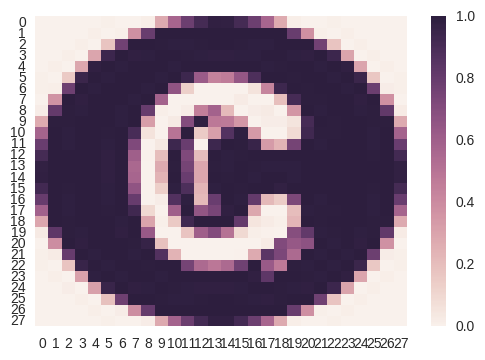

In [69]:
sns.heatmap(X_train[9212][0])